# EXAMPLES (TQL)
- [Tensor Query Language (TQL)](https://docs.activeloop.ai/examples/tql)
  - [TQL Syntax](https://docs.activeloop.ai/examples/tql/syntax)
  - [Index for ANN Search](https://docs.activeloop.ai/examples/tql/ann-index)
    - [Caching and Optimization](https://docs.activeloop.ai/examples/tql/ann-index/caching-and-optimization)
  - [**Sampling Datasets**](https://docs.activeloop.ai/examples/tql/sampling)

## Sampling Datasets

### Sample datasets using Deep Lake's query engine
*Sampling is often used when training models in order to modify the distribution of data that models are trained on. A common objective of samplers is to rebalance the data in order to achieve an more uniform distribution of classes in the training loop. Deep Lake provides a powerful API for several sampling methods via the query engine.*

*The general syntax for sampling is using the sample by keywords:*
```
select * sample by weight_choice(expression_1: weight_1, expression_2: weight_2, ...)
        replace True limit N
```
- *weight_choice resolves the weight that is used when multiple expressions evaluate to True for a given sample. Options are max_weight, sum_weight. For example, if weight_choice is max_weight, then the maximum weight will be chosen for that sample.*
- *replace determines whether samples should be drawn with replacement. It defaults to True.*
- *limit specifies the number of samples that should be returned. If unspecified, the sampler will return the number of samples corresponding to the length of the dataset*<br>

*Sampling can be performed in the query interface in the Deep Lake UI, or in the Python API as shown below.*

#### Example Usage

*Suppose we're working with a medical imaging dataset such as the NIH Chest X-Ray. Let's use samplers to create a more balanced view of the dataset that we can use for training a model. First, let's load the dataset:*<br>
**NIH Chest X-rays (Over 112,000 Chest X-ray images from more than 30,000 unique patients)**<br>
- [NIH Chest X-Ray (DeepLake)](https://app.activeloop.ai/activeloop/nih-chest-xray-train)<br>
- [NIH Chest X-Ray (Kaggle)](https://www.kaggle.com/datasets/nih-chest-xrays/data)
- [README_CHESTXRAY.pdf (Kaggle)]('README_CHESTXRAY.pdf')

In [16]:
# ERROR: AttributeError: module 'lib' has no attribute 'X509_V_FLAG_NOTIFY_POLICY'
# !pip install --upgrade pyOpenSSL

In [17]:
import deeplake
import numpy as np
from matplotlib import pyplot as plt

import os
from dotenv import load_dotenv

# Load environment variables 
load_dotenv(override = True)
open_api_key = os.getenv('OPENAI_API_KEY')
activeloop_token = os.getenv('ACTIVELOOP_TOKEN')

ds = deeplake.load('hub://activeloop/nih-chest-xray-train')

\

Opening dataset in read-only mode as you don't have write permissions.


-

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/nih-chest-xray-train



/

hub://activeloop/nih-chest-xray-train loaded successfully.



In [18]:
# Calculate the a histogram of the medical findings (findings tensor) and plot it

# Extract the list of class_names in a separate variable for re-use
class_names = ds.findings.info.class_names
num_classes = len(class_names)

class_count_raw = np.bincount(np.concatenate(ds.findings.numpy(aslist = True), axis=0))

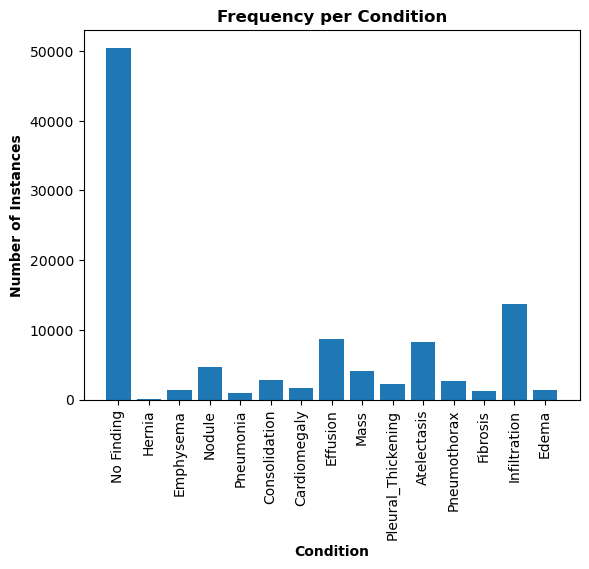

In [19]:
plt.bar(np.arange(num_classes), class_count_raw, tick_label = class_names)
plt.xlabel('Condition', weight='bold')
plt.xticks(rotation='vertical')
plt.ylabel('Number of Instances', weight='bold')
plt.title('Frequency per Condition', weight='bold')
plt.show()

*We observe that findings such as Hernia, Pneumonia, Fibrosis, Edema , and Emphysema are very rare, which may cause our model to underperform when predicting these conditions. Note that even though many images have No_Finding, this is desirable for avoiding false positives when training models for medical imaging applications.*

*Use Deep Lake Tensor-Query-Language to upsample the under-represented findings in order to create a more balanced dataset.*
```
select * sample by max_weight(contains(findings, 'Hernia'): 20, 
                               contains(findings, 'Pneumonia'): 8, 
                               contains(findings, 'Fibrosis'): 5, 
                               contains(findings, 'Edema'): 5,
                               contains(findings, 'Emphysema'): 2, True: 1)
```

In [ ]:
# We can run this query in the UI or in the Python API using ds.query(...)

balanced_view = ds.query("select * sample by max_weight(contains(findings, 'Hernia'): 20, contains(findings, 'Pneumonia'): 8, contains(findings, 'Fibrosis'): 5, contains(findings, 'Edema'): 5, contains(findings, 'Emphysema'): 2, True: 1)")

**ImportError: High performance features require the libdeeplake package which is not available in Windows OS**

In [ ]:
# In this sampler query, we're upsampling Hernia, by 20x, Pneumonia by 8x, Fibrosis by 5x, Edema by 5x, and Emphysema by 2x.
# Let's recalculate the histogram for the balanced dataset and compare it to the raw data histogram.

class_count_balanced = np.bincount(np.concatenate(balanced_view.findings.numpy(aslist = True), axis=0))

**ImportError: High performance features require the libdeeplake package which is not available in Windows OS**

In [ ]:
X_axis = np.arange(len(class_names))

plt.figure(figsize=(8, 4))

plt.bar(X_axis - 0.2, class_count_raw, 0.4, label = 'Raw Data')
plt.bar(X_axis + 0.2, class_count_balanced, 0.4, label = 'Sampled Data')
  
plt.xticks(X_axis, class_names)
plt.xlabel('Condition', weight='bold')
plt.xticks(rotation='vertical')
plt.ylabel('Number of Instances', weight='bold')
plt.title('Frequency per Condition', weight='bold')
plt.legend()
plt.show()

**ImportError: High performance features require the libdeeplake package which is not available in Windows OS**

*The data in the upsampled dataset has much better representation of the rare conditions. Note that since a given image may have multiple conditions, and since conditions can be correlated, upsampling by one condition may implicitly upsample another condition, if they tend to occur in the same image.*

#### Training Models on Sampled Views

In [ ]:
# The sampled dataset view can be passed to a dataloader just like an ordinary Deep Lake dataset.

pytorch_dataloader = balanced_view.pytorch(...)
for data in pytorch_dataloader:
    # Training loop

## COPY DATASET

In [ ]:
DATASET_PATH = "hub://activeloop/nih-chest-xray-train"
LOCAL_PATH = "./nih-chest-xray-train"  # 38,1 MB (40 files, 25 directories)

In [ ]:
def copy_dataset(dataset_path, local_path):
    # URL of the dataset in DeepLake hub
    # dataset_path = DATASET_PATH_1

    # Local path where you want to save the dataset
    # local_path = LOCAL_PATH_1

    # Download the dataset from hub to local storage
    deeplake.copy(
        src=dataset_path,
        dest=local_path,
        overwrite=True  # Set to False if you want to avoid overwriting existing data
    )

    # Load the local dataset to verify
    local_dataset = deeplake.load(local_path)
    print(f"Dataset downloaded from {dataset_path} and saved to {local_path}")
    print(local_dataset.summary())

In [ ]:
dataset = copy_dataset(DATASET_PATH, LOCAL_PATH)

## NIH Chest X-rays
#### Over 112,000 Chest X-ray images from more than 30,000 unique patients
**NIH Chest X-ray Dataset of 14 Common Thorax Disease Categories:**<br>
1. Atelectasis
2. Cardiomegaly
3. Effusion
4. Infiltration
5. Mass
6. Nodule
7. Pneumonia
8. Pneumothorax
9. Consolidation
10. Edema
11. Emphysema
12. Fibrosis
13. Pleural_Thickening
14. Hernia 

In [ ]:
from IPython.display import display, HTML

# Create a link to the local file
file_path = "README_CHESTXRAY.pdf"
html_content = f'<a href="{file_path}" target="_blank">README_CHESTXRAY.pdf</a>'

# Display the link
display(HTML(html_content))